## Making pleasing maps with cartopy

To make a pretty, publication grade map for your study area look no further than cartopy.

In this tutorial we will walk through generating a basemap with:
- Bathymetry/topography
- Coastline
- Scatter data
- Location labels
- Inset map
- Legend

This code can be generalised to any region you wish to map

First we import some modules for manipulating and plotting data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Then we import cartopy itself

In [2]:
import cartopy

In addition, we import cartopy's **coordinate reference system** submodule:

In [3]:
import cartopy.crs as ccrs

A few other modules and functions which we will use later to add cool stuff to our plots. Also updating font sizes for improved readability

In [4]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

plt.rcParams.update({'font.size': 20})

### Note on bathymetry data
To save space and time I have subset the bathymetry plotted in this example. If you wish to map a different area you will need to download the GEBCO topography data found [here](https://www.bodc.ac.uk/data/open_download/gebco/gebco_2021_sub_ice_topo/zip/) then run the two cells below. You'll only need to do this once.

In [5]:
# Add the path to your GEBCO bathy file and the limits of the area you wish to map
gebco_nc = "/home/callum/Documents/global_datasets/GEBCO_2019/GEBCO_2019.nc"

s_lim = 57
n_lim = 58
w_lim = -8
e_lim = -6

In [6]:
ds = xr.open_dataset(gebco_nc)
# Here we subet the bathymetry
ds_sub = ds.sel(lat=slice(s_lim-0.5, n_lim+0.5), lon=slice(w_lim-0.5, e_lim+0.5))
ds_sub.to_netcdf('bathy.nc')

Load the stored bathymetry data

In [7]:
bathy_ds = xr.open_dataset('./bathy.nc')
bathy_lon, bathy_lat, bathy_h = bathy_ds.lon, bathy_ds.lat, bathy_ds.elevation.values

We're just interested in bathy here, so set any height values greater than 0 to to 0

In [8]:
bathy_h[bathy_h>0] = 0

Check what the greatest depth is in the dataset to inform our choice of contour levels

In [9]:
bathy_h.min()

-342.238

In [10]:
bathy_conts = np.arange(-360, 30, 30)

Here we load some scatter data from a two column csv for plotting later

In [11]:
# Create random sampling locations within our map area
lons = w_lim + (e_lim-w_lim) *np.random.random_sample(10)
lats = s_lim + (n_lim-s_lim) * np.random.random_sample(10)

# Subset of sampling locations
sample_lon = lons[:3]
sample_lat = lats[:3]


Now to make the map itself. First we define our coordinate system, create figure and axes instances and set the plotting extent in degrees [West, East, South, North]. We're using the [Azimuthal Equidistant](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#azimuthalequidistant) projection here

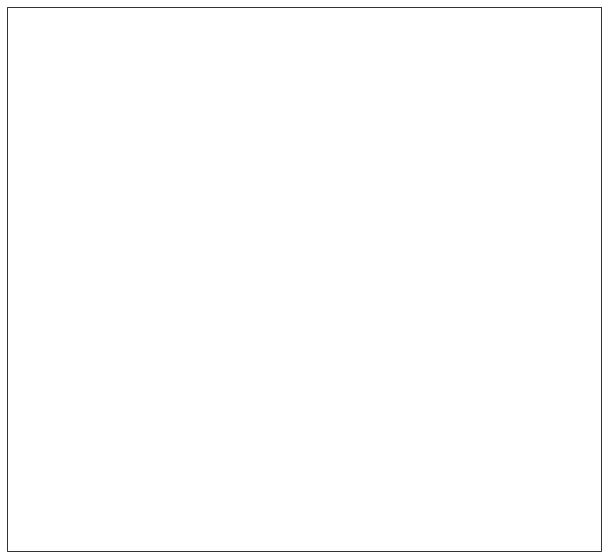

In [12]:
coord=ccrs.AzimuthalEquidistant(central_latitude=(n_lim +s_lim)/2, central_longitude=(w_lim + e_lim)/2)
pc = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)

Now we contour the bathymetry data

/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


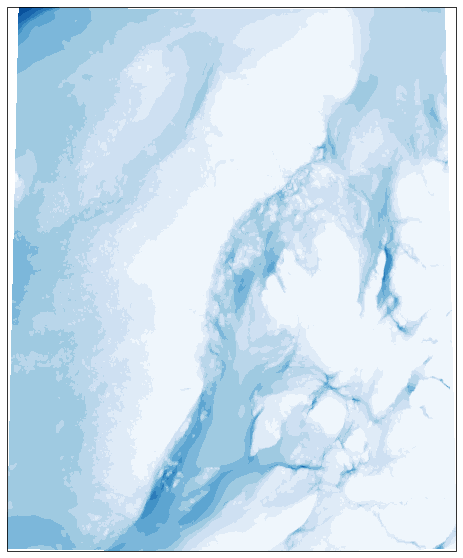

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
#ax.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=pc,cmap='Blues_r')

A good start. To make it more map like we add gridlines, formatted labels and a colorbar

/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


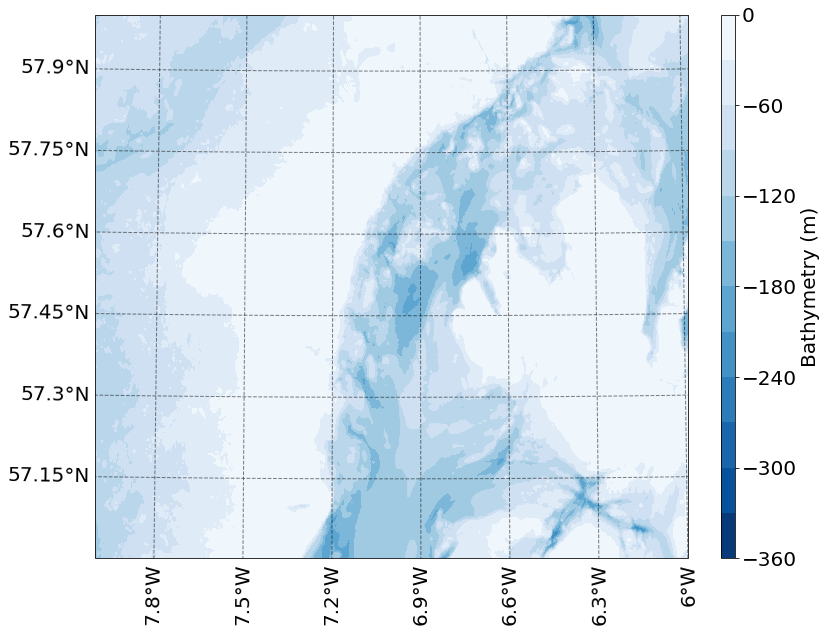

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=pc,cmap='Blues_r')

gl = ax.gridlines(crs=pc, draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
fig.colorbar(bathy,ax=ax,orientation='vertical',label='Bathymetry (m)',pad=0.03,aspect=40);

Now to add a few more features. First coastlines from cartopy's natural features toolbox. Then scatters of the samples we imported earlier

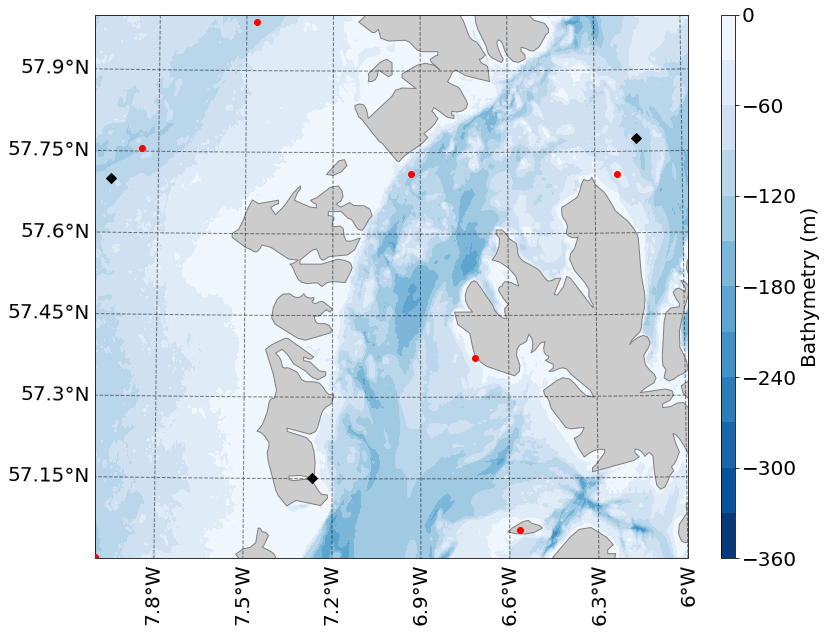

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=pc,cmap='Blues_r')

gl = ax.gridlines(crs=pc, draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True
fig.colorbar(bathy,ax=ax,orientation='vertical',label='Bathymetry (m)',pad=0.03,aspect=40)

feature = cartopy.feature.NaturalEarthFeature(name='land',
                                              category='physical',
                                              scale='10m',
                                              edgecolor='0.5',
                                              facecolor='0.8')
ax.add_feature(feature)
ax.scatter(lons,lats,zorder=5,color='red',label='Samples collected', transform=pc)
ax.scatter(sample_lon,sample_lat,zorder=10,color='k',marker='D',s=50,label='Samples sequenced', transform=pc);

To finish off the map we add a legend for the scatter plot, an inset map showing the area at a larger scale and some text identifying the islands

Text(-6.35, 57.25, 'Skye')

/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/callum/anaconda3/envs/cartopy-basemap/lib/python3.10/site-packages/cartopy/crs.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings.extend(multi_lin

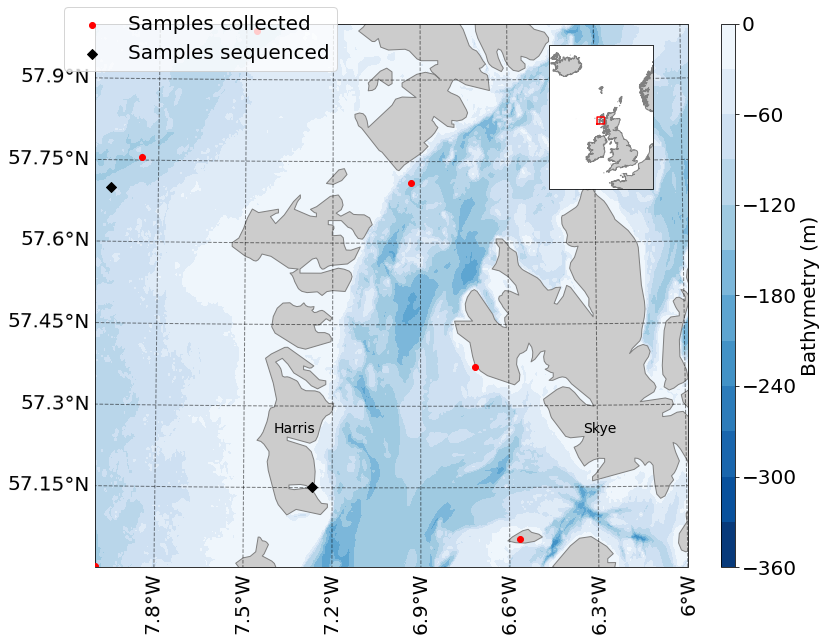

In [16]:
# Initiate the figure and axes, specifying the projection.
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection=coord)

# Set the extent of the map [W,E,S,N]
ax.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)

# Plot the bathymetry here, could change the contour levels by making a new bathy_conts
# or try a different colormap
bathy=ax.contourf(bathy_lon,bathy_lat,bathy_h,bathy_conts,transform=pc,cmap='Blues_r')

# Set the color and style of the gridlines
gl = ax.gridlines(crs=pc, draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='--')

# Format those gridlines, turn off labels on the top and right side
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylines = True
gl.xlines = True

# Add a colorbar for the bathymetry data
fig.colorbar(bathy,ax=ax,orientation='vertical',label='Bathymetry (m)',pad=0.03,aspect=40)

# Add the coastlines
ax.add_feature(feature)

# Add the scatter data, we could change the symbols
ax.scatter(lons,lats,zorder=5,color='red',label='Samples collected', transform=pc)
ax.scatter(sample_lon,sample_lat,zorder=10,color='k',marker='D',s=50,label='Samples sequenced', transform=pc)

# Add the legend, try changing its position
fig .legend( bbox_to_anchor=(0.32,0.8),loc='lower left')

# Here we add the inset map sub axes in the top right, note the different projection
tr2=ccrs.Stereographic(central_latitude=(n_lim + s_lim)/2, central_longitude=(w_lim+e_lim)/2)
sub_ax = plt.axes([0.6, 0.65, 0.2, 0.2], projection=tr2)
# Try changing the extent of our inset map here
sub_ax.set_extent([w_lim-10,e_lim+10, s_lim-10, n_lim+10], crs=pc)

# Here we make a line that plots the vertices of our main plot to put on the inset map
x_co = [w_lim, e_lim, e_lim, w_lim, w_lim]
y_co = [s_lim, s_lim, n_lim, n_lim, s_lim]

sub_ax.add_feature(feature)
sub_ax.plot(x_co,y_co,transform=pc,zorder=10,color='red');

# Finally we add a couple of text labels for the islands
ax.text(-7.4, 57.25, 'Harris',fontsize=14, transform=pc)
ax.text(-6.35, 57.25,'Skye',fontsize=14, transform=pc)

#ax.text(-26.8,-58.2,'South\nSandwich\nIslands',transform=pc, fontsize=14);

### Notes on coastlines

cartopy has inbuilt coastlines at three levels of precision.These are expressed in how they scale to the real coastlines, from 1:110 million (most coarse) to 1:10 million (most fine).

In [17]:
coasts_10m = cartopy.feature.NaturalEarthFeature(name='land',
                                              category='physical',
                                              scale='10m',
                                              edgecolor='0.5',
                                              facecolor='0.8')
coasts_50m = cartopy.feature.NaturalEarthFeature(name='land',
                                              category='physical',
                                              scale='50m',
                                              edgecolor='0.5',
                                              facecolor='0.8')
coasts_110m = cartopy.feature.NaturalEarthFeature(name='land',
                                              category='physical',
                                              scale='110m',
                                              edgecolor='0.5',
                                              facecolor='0.8')

s_lim = 57
n_lim = 58
w_lim = -8
e_lim = -4

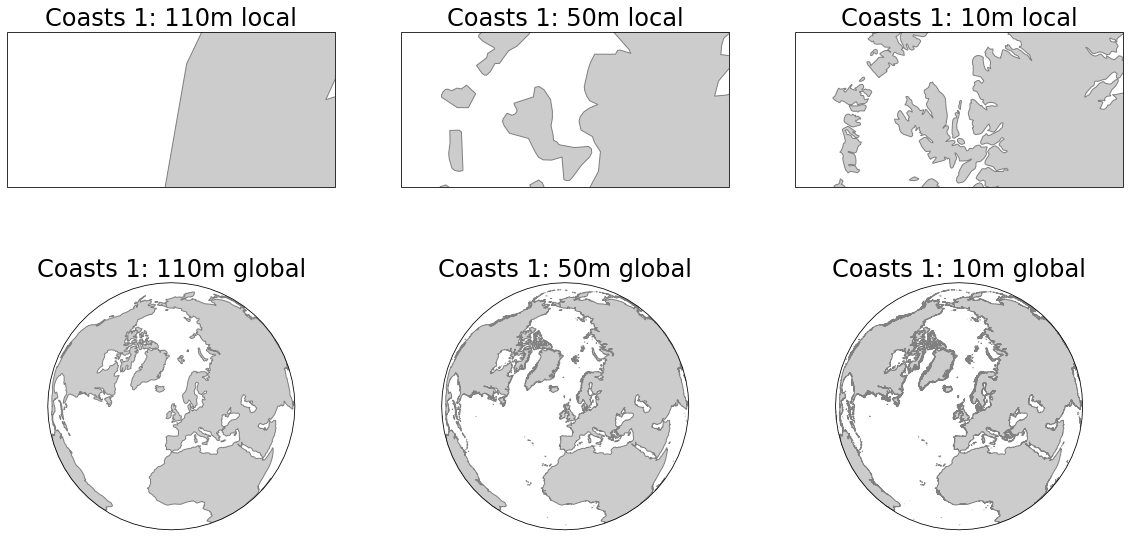

In [18]:
fig = plt.figure(figsize=(20,10))

globe = ccrs.Orthographic(central_latitude=(n_lim + s_lim)/2, central_longitude=(w_lim+e_lim)/2)

ax0 = fig.add_subplot(231, projection=coord)
ax1 = fig.add_subplot(232, projection=coord)
ax2 = fig.add_subplot(233, projection=coord)
ax3 = fig.add_subplot(234, projection=globe)
ax4 = fig.add_subplot(235, projection=globe)
ax5 = fig.add_subplot(236, projection=globe)

ax0.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax0.add_feature(coasts_110m)
ax0.set_title('Coasts 1: 110m local')

ax1.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax1.add_feature(coasts_50m)
ax1.set_title('Coasts 1: 50m local')

ax2.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax2.add_feature(coasts_10m)
ax2.set_title('Coasts 1: 10m local')

ax3.set_global()
ax3.add_feature(coasts_110m)
ax3.set_title('Coasts 1: 110m global')

ax4.set_global()
ax4.add_feature(coasts_50m)
ax4.set_title('Coasts 1: 50m global')

ax5.set_global()
ax5.add_feature(coasts_10m)
ax5.set_title('Coasts 1: 10m global');


The 110m scale is good for continent scale maps, as the polygons are much simpler, so complex coastlines are less crowded than with 10m. 10m scale is the best availale within cartopy for small scale mapping.

### Hi-def coastlines

However, 1: 10m is still far from perfect, especially at the sub 10 km scale. For very finescale mapping, or when you want to plot your own coastlines/contours, cartopy offers the sharereader library to read in your own shapefiles.

Shapefiles are used by cartographers to store vector data. A good source for these shapefiles is [openstreetmaps coastlines](https://osmdata.openstreetmap.de/data/land-polygons.html). These are a highly detailed coastlines used in a lot of web apps. Because of their high level of detail, these shafefiles are impractically large. Attemping to plot all of the coastlines at this detail level would take a very long time and likely crash our Python script so, before we plot them, it is necessary to subset the shapefiles. This can be achieved through a GIS program like Arc or Q GIS, or you can use the [gdal](https://gdal.org/) tool directly from the command line. GDAL can be a pain to install, but cartopy from conda comes with GDAL included, so you should have all you need. Activate your conda environment which has cartopy in and run the GDAL clip command to extract the coastlines you want

The command for extracting a subset of coastlines from GDAL looks like this:

`ogr2ogr -f "ESRI Shapefile" hidf_land.shp /path/to/openstreetmaps/land_polygons.shp -clipsrc $1 $2 $3 $4`
where the four numbers at end are western bound southern bound eastern bound and northern bound in degrees. Longitude is from -180 to 180

It's good practice to extend your area by a small distance to make sure you fully capture any polygons that will be particaly covered by your map. In this case, the command used is be:

`ogr2ogr -f "ESRI Shapefile" hidf_land.shp /path/to/openstreetmaps/land_polygons.shp -clipsrc -9 56 -3 59`

I have saved the resulting files to the fodler "shapefiles". Let's see how they compare to the default coastlines, focusing on the isle of Lewis. The difference is apparent at this sub 10 km scale.

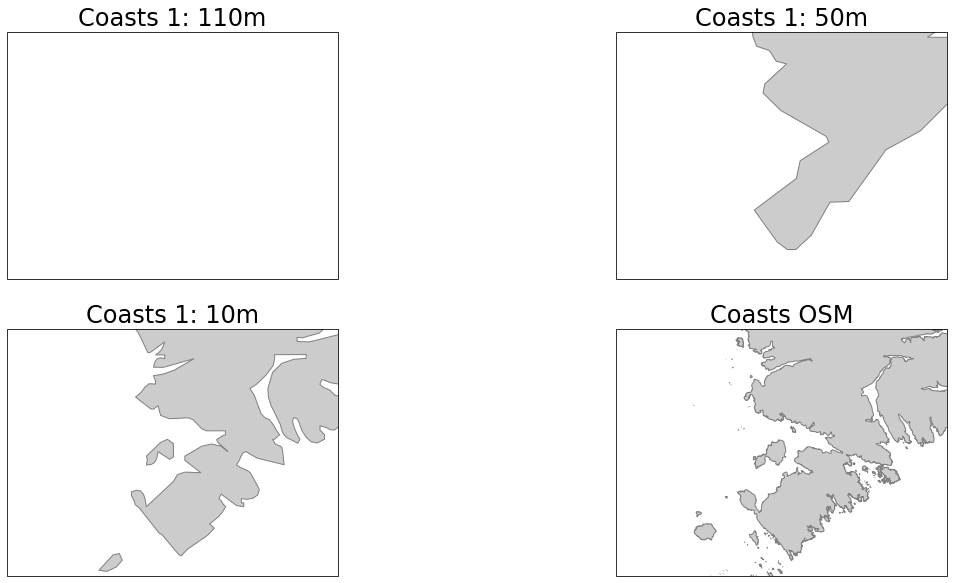

In [19]:
s_lim = 57.7
n_lim = 58.1
w_lim = -7.5
e_lim = -6.5

fig = plt.figure(figsize=(20,10))

ax0 = fig.add_subplot(221, projection=coord)
ax1 = fig.add_subplot(222, projection=coord)
ax2 = fig.add_subplot(223, projection=coord)
ax3 = fig.add_subplot(224, projection=coord)


ax0.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax0.add_feature(coasts_110m)
ax0.set_title('Coasts 1: 110m')

ax1.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax1.add_feature(coasts_50m)
ax1.set_title('Coasts 1: 50m')

ax2.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)
ax2.add_feature(coasts_10m)
ax2.set_title('Coasts 1: 10m')

ax3.set_extent([w_lim, e_lim, s_lim, n_lim], crs=pc)

shp = shapereader.Reader('shapefiles/hidf_land.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax3.add_geometries([geometry], ccrs.PlateCarree(), edgecolor='0.5', facecolor='0.8')
ax3.set_title('Coasts OSM');
